# BERT

In [1]:
import os
import random
import functools
import csv
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pandas as pd
import bitsandbytes, accelerate

2024-06-26 11:31:54.840894: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# define custom batch preprocessor
def collate_fn(batch, tokenizer):
    dict_keys = ['input_ids', 'attention_mask', 'labels']
    d = {k: [dic[k] for dic in batch] for k in dict_keys}
    d['input_ids'] = torch.nn.utils.rnn.pad_sequence(
        d['input_ids'], batch_first=True, padding_value=float(pad_token_id)
    )
    d['attention_mask'] = torch.nn.utils.rnn.pad_sequence(
        d['attention_mask'], batch_first=True, padding_value=float(pad_token_id)
    )
    d['labels'] = torch.stack(d['labels'])
    return d

In [3]:
class CustomTrainer(Trainer):

    def __init__(self, label_weights, **kwargs):
        super().__init__(**kwargs)
        self.label_weights = label_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # compute custom loss
        loss = F.binary_cross_entropy_with_logits(logits, labels.to(torch.float32), pos_weight=self.label_weights)
        return (loss, outputs) if return_outputs else loss

In [4]:
# disable progress bars when submitting
def is_interactive():
   return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()
N_LABELS = 30 #主标签+辅助标签

In [5]:
max_features = None

train = pd.read_csv('../dataset/train.csv')
# test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

# x_train = preprocess(train['comment_text'])
x_train = train['comment_text']
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target']+list(train.columns[3:32])]
y_aux_train = y_aux_train.applymap(lambda x: 1 if x > 0.5 else 0)


# 均衡化数据集
# 确定数量较少的类别
count_class_0 = np.sum(y_train == 0)
count_class_1 = np.sum(y_train == 1)

# 从数量较多的类别中随机抽样
index_class_0 = np.where(y_train == 0)[0]
index_class_1 = np.where(y_train == 1)[0]

# 从数量较多的类别中随机选择与数量较少的类别相同数量的样本
seed_everything()
selected_index_class_0 = np.random.choice(index_class_0, count_class_1, replace=False)

# 构建平衡的数据集
x_train = np.concatenate([x_train[selected_index_class_0], x_train[index_class_1]])
y_train = np.concatenate([y_train[selected_index_class_0], y_train[index_class_1]])
y_aux_train = np.concatenate([y_aux_train.iloc[selected_index_class_0], y_aux_train.iloc[index_class_1]])

# 划分训练集和测试集，按照9:1的比例
x_train, x_test, y_train, y_test, y_aux_train, y_aux_test = train_test_split(
    x_train, y_train, y_aux_train, test_size=0.1, random_state=1624)


In [6]:
# create hf dataset
ds = DatasetDict({
    'train': Dataset.from_dict({'text': x_train, 'labels': y_aux_train}),
    'val': Dataset.from_dict({'text': x_test, 'labels': y_aux_test})
})
label_weights = np.ones((N_LABELS))

In [7]:
# model name
model_name = 'bert-base-uncased'

# preprocess dataset with tokenizer
def tokenize_examples(examples, tokenizer):
    tokenized_inputs = tokenizer(examples['text'])
    tokenized_inputs['labels'] = examples['labels']
    return tokenized_inputs

tokenizer = AutoTokenizer.from_pretrained('./BERT')
tokenizer.pad_token = tokenizer.eos_token
tokenized_ds = ds.map(functools.partial(tokenize_examples, tokenizer=tokenizer), batched=True)
tokenized_ds = tokenized_ds.with_format('torch')
pad_token_id = 0

Map:   0%|          | 0/259801 [00:00<?, ? examples/s]

Map:   0%|          | 0/28867 [00:00<?, ? examples/s]

In [8]:
def collate_fn(batch, tokenizer, pad_token_id):
    max_length = max(len(sample['input_ids']) for sample in batch)
    input_ids = []
    attention_masks = []
    labels = []

    for sample in batch:
        input_id = sample['input_ids']
        attention_mask = sample['attention_mask']
        label = sample['labels']

        # Padding
        padding_length = max_length - len(input_id)
        padded_input_id = torch.cat([input_id, torch.tensor([pad_token_id] * padding_length, dtype=torch.long)])
        padded_attention_mask = torch.cat([attention_mask, torch.zeros(padding_length, dtype=torch.long)])

        input_ids.append(padded_input_id)
        attention_masks.append(padded_attention_mask)
        labels.append(label)

    return {
        'input_ids': torch.stack(input_ids),
        'attention_mask': torch.stack(attention_masks),
        'labels': torch.stack(labels)
    }

In [9]:
def load_model_and_tokenizer(model_path, num_labels):
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

In [10]:
# 评估函数
def evaluate_model(model, tokenizer, eval_dataset, batch_size=8):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    val_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, tokenizer, pad_token_id))
    
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            
            probabilities = torch.sigmoid(logits).cpu().numpy()  # sigmoid 转换
            predictions = (probabilities >= 0.5).astype(int)  # 二进制预测

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
    
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    labels_binary = (all_labels >= 0.5).astype(int)
    
    # 选择第一个类别进行评估
    class_index = 0
    labels_class = all_labels[:, class_index]
    binary_labels_class = labels_binary[:, class_index]
    predictions_class = all_predictions[:, class_index]
    probabilities_class = all_probabilities[:, class_index]

    accuracy_class = accuracy_score(labels_class, predictions_class)
    recall_class = recall_score(labels_class, predictions_class)
    # 这里auc, roc是用两个0/1值算的
    auc = roc_auc_score(binary_labels_class, predictions_class)
    cm = confusion_matrix(labels_class, predictions_class)

    print(f"Validation Accuracy: {accuracy_class}")
    print(f"Validation Recall: {recall_class}")
    print(f"Validation AUC: {auc}")
    print(f"Confusion Matrix:\n{cm}")

    # 绘制ROC曲线
    fpr, tpr, thresholds = roc_curve(binary_labels_class, predictions_class)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return all_labels, all_probabilities

Evaluating model: lora-bert-alltagged-4epoch


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./BERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.8561333010011432
Validation Recall: 0.8741596439731086
Validation AUC: 0.8599466416085362
Confusion Matrix:
[[15482  2824]
 [ 1329  9232]]


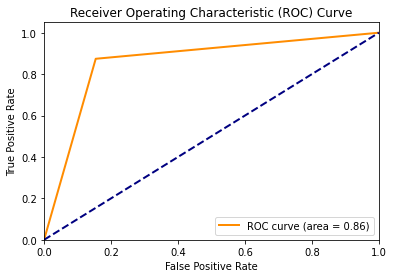

In [11]:
eval_dataset = tokenized_ds['val']
model_paths = ['lora-bert-alltagged-4epoch']


all_probabilities = []

for model_path in model_paths:
    print(f"Evaluating model: {model_path}")
    model, tokenizer = load_model_and_tokenizer(model_path, N_LABELS)
    all_labels, probabilities_class = evaluate_model(model, tokenizer, eval_dataset)
    all_probabilities.append(probabilities_class)

# LSTM

In [12]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm.notebook import tqdm
from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

In [13]:
# disable progress bars when submitting
def is_interactive():
   return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop

In [14]:
NUM_MODELS = 1
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220

In [15]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [16]:
max_features = None

train = pd.read_csv('../dataset/train.csv')
# test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

x_train = preprocess(train['comment_text'])
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]

In [17]:
# 均衡化数据集
# 确定数量较少的类别
count_class_0 = np.sum(y_train == 0)
count_class_1 = np.sum(y_train == 1)

# 从数量较多的类别中随机抽样
index_class_0 = np.where(y_train == 0)[0]
index_class_1 = np.where(y_train == 1)[0]

# 从数量较多的类别中随机选择与数量较少的类别相同数量的样本
seed_everything()
selected_index_class_0 = np.random.choice(index_class_0, count_class_1, replace=False)

# 构建平衡的数据集
x_train = np.concatenate([x_train[selected_index_class_0], x_train[index_class_1]])
y_train = np.concatenate([y_train[selected_index_class_0], y_train[index_class_1]])
y_aux_train = np.concatenate([y_aux_train.iloc[selected_index_class_0], y_aux_train.iloc[index_class_1]])


In [18]:
# 划分训练集和测试集，按照9:1的比例
x_train, x_test, y_train, y_test, y_aux_train, y_aux_test = train_test_split(
    x_train, y_train, y_aux_train, test_size=0.1, random_state=1624)

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

max_features = max_features or len(tokenizer.word_index) + 1
max_features

122578

In [19]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()
y_train_baseline = torch.tensor(y_train, dtype=torch.float32).cuda()

In [20]:
CRAWL_EMBEDDING_PATH = '../WordEmbedding/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../WordEmbedding/glove.840B.300d.txt'

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [21]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (crawl):  38008
n unknown words (glove):  36611


In [22]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

0

In [23]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [24]:
model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
model.cuda()
model.load_state_dict(torch.load('Model/LSTM model0.pth'))

batch_size = 32  # 调整为适当的批处理大小
num_samples = x_test_torch.size(0)
num_batches = (num_samples + batch_size - 1) // batch_size  # 计算总批次数

model.eval()  # 将模型设置为评估模式

predictions = []

with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch_inputs = x_test_torch[start_idx:end_idx]

        # 进行推断
        batch_outputs = model(batch_inputs)
        predictions.append(batch_outputs)

# 合并所有预测结果
predictions = torch.cat(predictions, dim=0)[:, :1] .squeeze()
predictions.shape
all_probabilities.append(np.array(predictions.cpu()))
all_probabilities[0] = all_probabilities[0][:, :1] .squeeze()

# ensemble

In [25]:
np.array(all_probabilities).shape

(2, 28867)

Ensemble Model Validation Accuracy: 0.8924723732982298
Ensemble Model Validation Recall: 0.8981552384267316
Ensemble Model Validation AUC: 0.8924992162344663
Ensemble Model Confusion Matrix:
[[12861  1641]
 [ 1463 12902]]


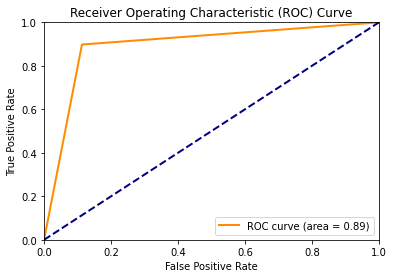

In [31]:
# ensemble_probabilities = np.mean(all_probabilities, axis=0)

weights = weights = np.array([0.5, 0.5])
ensemble_probabilities = np.average(np.array(all_probabilities), axis=0,weights=weights)


ensemble_predictions = (ensemble_probabilities >= 0.5).astype(int)

# 评估集成模型
labels_binary = (all_labels >= 0.5).astype(int)
    
# 选择第一个类别进行评估
class_index = 0
# labels_class = 
binary_labels_class = labels_binary
predictions_class = ensemble_predictions
probabilities_class = ensemble_probabilities

accuracy_class = accuracy_score(y_test, predictions_class)
recall_class = recall_score(y_test, predictions_class)
auc = roc_auc_score(y_test, predictions_class)
cm = confusion_matrix(y_test, predictions_class)

print(f"Ensemble Model Validation Accuracy: {accuracy_class}")
print(f"Ensemble Model Validation Recall: {recall_class}")
print(f"Ensemble Model Validation AUC: {auc}")
print(f"Ensemble Model Confusion Matrix:\n{cm}")

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, predictions_class)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()